**Qustion: Can IMU data of a frame be used to predict the active duty cycles (meaningful states detected)?** 

Here we treat it as a binary classification problem.  IMU data -> active cycle (T/F)

In [227]:
from __future__ import absolute_import, division, print_function

import collections
import glob
import itertools
import json
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import sqlalchemy as sa

from rmexp import dbutils, config
from rmexp import schema
from rmexp.schema import models

In [228]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from scipy.ndimage.filters import gaussian_filter1d

In [229]:
def insert_or_update_one(sess, model, keys_dict, vals_dict):
    record = sess.query(model).filter_by(**keys_dict).one_or_none()
    if record is not None:
        record.update(vals_dict)
    else:
        create_dict = {}
        create_dict.update(keys_dict)
        create_dict.update(vals_dict)
        record = model(**create_dict)
        sess.add(record)
    return record

In [244]:
APP = "ikea"

if APP == 'lego':
    ## settings for Lego
    # 5 and 8 lack patterns
    TRAIN_TRACES = ['lego-tr' + str(i) for i in (1, 2, 3, 4, 6)]
    TEST_TRACES = ['lego-tr' + str(i) for i in (1, 2, 3, 4, 6)]
    HANDLABELED_PASSIVE = {}
    HANDLABELED_ACTIVE = {
        'lego-tr1': [
            (230, 330),
            (430, 560),
            (730, 920),
            (1000, 1300),
            (1600, 1760),
            (2088, 2200),
            (2400, 2605),
        ],
        'lego-tr2': [
            (160, 390),
            (600, 850),
            (990, 1250),
            (1300, 1560),
            (1790, 2100),
            (2200, 2480),
            (2700, 2981),
            
        ],
        'lego-tr3': [
            (300, 500),
            (630, 860),
            (1090, 1290),
            (1360, 1660),
            (1800, 2000),
            (2200, 2480),
            (2660, 2858),
        ],
        'lego-tr4': [
            (200, 330),
            (560, 810),
            (1100, 1360),
            (1530, 1750),
            (1950, 2130),
            (2450, 2660),
            (2860, 3030),
            
        ],
        'lego-tr6': [
            (150, 330),
            (600, 800),
            (1400, 1560),
            (2200, 2440),
            (2700, 2900),
            (3240, 3500),
            (3850, 4083),
            
        ]
    }
#     HANDLABELED_PASSIVE = {
#         'lego-tr2': [
#             (13.5*30, 17.5*30),
#             (28.5*30, 32.5*30),
#             (43.5*30, 45.5*30),
#             (54.5*30, 60.5*30),
#             (73.5*30, 76.5*30),
#             (85.5*30, 92.5*30),
#         ],
#     }
    def filter_active(ss_df):
        return ss_df['val'].str.contains('\[\[')
    
elif APP == 'pingpong':
    ## settings for Ping Pong
    # 6-10 are longer traces Junjue and zf recorded
    TRAIN_TRACES = ['pingpong-tr' + str(i) for i in (6, 7, 8, 9, 10)]
    TEST_TRACES = ['pingpong-tr' + str(i) for i in (6, 7, 8, 9, 10)]
#     HANDLABELED_PASSIVE = {
#         'pingpong-tr10': [
#             ( 8.5*30, 12.5*30),
#             (33.5*30, 45.5*30),
#             (57.5*30, 63.5*30),
#             (64.5*30, 69.5*30),
#         ]
#     }
    HANDLABELED_ACTIVE = {}
    def filter_active(ss_df):
        return ~(ss_df['val'].str.contains('Cannot find table')
                | ss_df['val'].str.contains('Detected table too small')
                | ss_df['val'].str.contains('Table top line')
                | ss_df['val'].str.contains('Table doesn\'t occupy')
                | ss_df['val'].str.contains('Angle between two side')
                | ss_df['val'].str.contains('Valid area too small')
               )
elif APP == "pool":
    TRAIN_TRACES = ['pool-tr' + str(i) for i in range(1,5)]
    TEST_TRACES = ['pool-tr' + str(i) for i in range(1,5)]
    def filter_active(ss_df):
        return ~(ss_df['val'].str.contains('Cannot find'))
    #Thresholds used thresholds = [1.0,1.2,1.0,1.4] y_pred = 1 - X[:,0]>threshold
elif APP == "ikea":
    TRAIN_TRACES = ['ikea-tr' + str(i) for i in [1, 3, 4, 5]]
    TEST_TRACES = ['ikea-tr' + str(i) for i in [1, 3, 4, 5]]
#     TEST_TRACES = ['ikea-tr' + str(i) for i in range(1,8)]
    HANDLABELED_ACTIVE = {
        'ikea-tr1': [
            (6*30, 11*30),
            (23*30, 30*30),
            (39*30, 47*30),
            (71*30, 85*30),
            (92*30, 99*30),
            (122*30, 128*30),
            (137*30, 148*30),
            (162*30, 174*30),
        ],
        'ikea-tr3': [
            (6*30, 15*30),
            (30*30, 40*30),
            (52*30, 59*30),
            (84*30, 93*30),
            (102*30, 109*30),
            (131*30, 138*30),
            (144*30, 155*30),
            (167*30, 179*30),
        ],
        'ikea-tr4': [
            (5*30, 14*30),
            (27*30, 37*30),
            (43*30, 51*30),
            (66*30, 98*30),
            (104*30, 110*30),
            (133*30, 138*30),
            (144*30, 158*30),
            (168*30, 180*30),
        ],
        'ikea-tr5': [
            (6*30, 12*30),
            (30*30, 38*30),
            (45*30, 52*30),
            (76*30, 94*30),
            (108*30, 114*30),
            (134*30, 140*30),
            (144*30, 157*30),
            (166*30, 178*30),
        ],    
        }
    def filter_active(ss_df):
        return ~(ss_df['val'].str.contains('No objects detected'))

        

In [197]:
# load IMU csv files into MySQL

def load_IMU_to_DB(trace_name, base_dir):
    trace_num = re.search('\d+', trace_name).group(0)
    csv_name = glob.glob(os.path.join(base_dir,
                                      trace_num, '*.csv'))[0]
    print("Using file as IMU data:", csv_name)
    df = pd.read_csv(csv_name,index_col='frame_id')
    df['sensor_timestamp'] = pd.to_datetime(df['sensor_timestamp'])
    
    new = 0
    for row in df.itertuples():
        keys_dict = {'name': trace_name,
                     'trace': trace_num,
                     'index': row.Index
                    }
        vals_dict = {'sensor_timestamp': row.sensor_timestamp.to_pydatetime(),
                     'rot_x': row.rot_x,
                     'rot_y': row.rot_y,
                     'rot_z': row.rot_z,
                     'acc_x': row.acc_x,
                     'acc_y': row.acc_y,
                     'acc_z': row.acc_z
                    }
        
        insert_or_update_one(sess, models.IMU, keys_dict, vals_dict)

    print("Updated: ", len(sess.dirty))
    print("New: ", len(sess.new))
    sess.commit()

# sess = dbutils.get_session()
# for trace_name in set(TRAIN_TRACES + TEST_TRACES):
#     load_IMU_to_DB(trace_name, '/home/junjuew/work/resource-management/data/ikea-trace')
# sess.close()

Using file as IMU data: /home/junjuew/work/resource-management/data/ikea-trace/13/2019_05_18-17_09_09.csv


/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/ipykernel_launcher.py:38: UserWarning: Discarding nonzero nanoseconds in conversion


AttributeError: 'IMU' object has no attribute 'update'

In [247]:
def train_clf(trace_names, 
              svm_kargs={}, 
              X_transform_func=lambda x: x, 
              param_grid = {'svm__C': [1., 10.], 'svm__kernel': ['linear',]}):
    Xs = []
    ys = []
    
    for trace in trace_names:
        X1, y1 = get_raw_Xy(trace)
        X1 = X_transform_func(X1)
        Xs.append(X1)
        ys.append(y1)
    
    X = np.vstack(Xs)
    y = np.concatenate(ys)
    print(X.shape)
    print("Total frames: ", X.shape[0], "Active frames: ", np.count_nonzero(y))
    
#     skf = StratifiedKFold(n_splits=5)
    
    clf = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('svm', SVC(**svm_kargs)),
    ])
    
    clf = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=4)

    clf.fit(X, y)
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
#     print("Training confusion matrix:\n", cm)
    return clf, cm, (X, y, y_pred)

def eval_clf(clf, trace_names, X_transform_func=lambda x:x, threshold=0):
    Xs = []
    ys = []
    for trace in trace_names:
        X1, y1 = get_raw_Xy(trace)
        X1 = X_transform_func(X1)
        Xs.append(X1)
        ys.append(y1)
        
    X = np.vstack(Xs)
    y = np.concatenate(ys)
    
#     y_pred = np.ones_like(y) - (X[:,0]>threshold)
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return cm, (X, y, y_pred)

In [232]:
# calibration data using zero-movement readings
#  select avg(rot_x), avg(rot_y), avg(rot_z), avg(acc_x), avg(acc_y), avg(acc_z) from IMU where name = "lego-tr0";
IMU_CALIBRATE = [0.0006005733204134366, -0.0010699289405684755, 0.0010396479328165374,
                -0.4246709463824289, 10.076913759689923, 0.31374152131782945]

# the -tr0 IMU readings from lego and pingpong are quite different ...

In [248]:
# Classifiction problem: 
# Features: 6 IMU readings per frame -> transform_func -> X
# Label y: 0 - passive, 1 - active.
# use SVM with GridSearch

def get_raw_Xy(trace, calibrate=True):
    imu_df = get_IMU_pd(trace)    
    use_imu_cols = ['rot_x','rot_y','rot_z','acc_x','acc_y','acc_z']
    X1 = imu_df[use_imu_cols].values
    if calibrate:
        # adjust for calibration
        X1 = X1 - np.array(IMU_CALIBRATE)
    
    # if we have hand labeled passive phase, use it.
    # otherwise use computer vision SS to proxy ground truth
    if trace in HANDLABELED_PASSIVE:
        print("Using hand labeled GT:", trace)
        y1 = np.ones_like(X1[:, 0])
        for start, end in HANDLABELED_PASSIVE[trace]:
            start = int(start)
            end = int(end)
            y1[start-1: end] = 0
    elif trace in HANDLABELED_ACTIVE:
        print("Using hand labeled GT:", trace)
        y1 = np.zeros_like(X1[:, 0])
        for start, end in HANDLABELED_ACTIVE[trace]:
            y1[start: end] = 1
    else:
        ss_df = get_SS_pd(trace)
        # SS sometimes has one more frame than IMU, drop it
        ss_df = ss_df[ss_df['index'] <= imu_df['index'].max()]
        y1 = np.zeros_like(X1[:, 0])
        active_inds = ss_df[filter_active(ss_df)]['index'].values
        y1[active_inds] = 1 

    
    print("%s has %d/%d active/total frames" % (trace, np.count_nonzero(y1), y1.shape[0]))
    return X1, y1

In [249]:
# reading from MySQL using Pandas API

def get_SS_pd(trace_name):
    df = pd.read_sql('SELECT * FROM SS WHERE name = %s', schema.engine, params=[trace_name,])
    df['index'] = df['index'].astype(int) - 1   # SS's index counts from 1
    df = df.sort_values('index')
    return df
    
def get_IMU_pd(trace_name):
    df = pd.read_sql('SELECT * FROM IMU WHERE name = %s', schema.engine, params=[trace_name,])
    df['index'] = df['index'].astype(int)
    df = df.sort_values('index')
    return df

In [250]:
# manually engineered features
# select acc_x, acc_y, Gaussian smooth, and substract cummulative mean

def past_windowed_1d(x, size, func):
    # output[i] -> func(x[i-size+1:i+1])
    # aka windowed function on the past `size` frames
    # should only call on one trace
    assert x.ndim == 1
    rv = []
    for i in range(x.shape[0]):
        wind = x[max(0, i - size + 1): i+1]  # including i
        rv.append(func(wind))
        
    return np.array(rv)

def transform_acc_x(X_imu6):
    accx = X_imu6[:,3]  # acc_x
    accy = X_imu6[:,4] # acc_y
    accz = X_imu6[:,4] # acc_z
    
    accx_smooth_mean = past_windowed_1d(accx, accx.shape[0],
                                   lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))
    accy_smooth_mean = past_windowed_1d(accy, accy.shape[0],
                                   lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))
    accz_smooth_mean = past_windowed_1d(accz, accz.shape[0],
                                   lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))
    
    X_combined = np.stack([accx_smooth_mean, accy_smooth_mean, accz_smooth_mean], axis=1)
    return X_combined

In [237]:
# Retrain using a chosen trade-off
W = 1.
if APP == 'lego':
    W = 4.5
elif APP == 'pingpong':
    W = 2.
elif APP == 'pool':
    W = 1.
elif APP == 'ikea':
    W = 3.0
svm_kargs={'class_weight': {0: 1.0, 1: W}, 'random_state': 42, 'verbose': True},
clf, cm, _ = train_clf(TRAIN_TRACES, 
                        X_transform_func=transform_acc_x,
                        svm_kargs={'class_weight': {0: 1.0, 1: W}, 'random_state': 42, 'verbose': True, 'probability': True},
                        param_grid = {'svm__C': [1.,10.], 'svm__kernel': ['rbf','linear']})
print(cm)
# thresholds = [1.3,1.32,1.35,1.36,1.4]
# for threshold in thresholds:
#     print("Threshold: ",threshold)
cm, _ = eval_clf(clf, TEST_TRACES, X_transform_func=transform_acc_x, threshold=threshold)
print("Eval cm:\n", cm)

# clf = clf.best_estimator_
# thresholds = [0.5]
# for threshold in thresholds:
#     print("Threshold: ",threshold)
#     cm, _ = eval_clf(clf, TEST_TRACES, X_transform_func=transform_acc_x, threshold=threshold)
#     print("Eval cm:\n", cm)
with open('IMU_' + APP + '_clf.pkl', 'w') as f:
    pickle.dump(clf, f)
# print("OK")

test-ikea-10
Using hand labeled GT: test-ikea-10
test-ikea-10 has 2100/5365 active/total frames
test-ikea-11
Using hand labeled GT: test-ikea-11
test-ikea-11 has 2160/5618 active/total frames
test-ikea-12
Using hand labeled GT: test-ikea-12
test-ikea-12 has 2520/4911 active/total frames
test-ikea-13
Using hand labeled GT: test-ikea-13
test-ikea-13 has 1920/4723 active/total frames
(20617, 3)
Total frames:  20617 Active frames:  8700
[LibSVM][[2149 9768]
 [ 442 8258]]
test-ikea-10
Using hand labeled GT: test-ikea-10
test-ikea-10 has 2100/5365 active/total frames
test-ikea-11
Using hand labeled GT: test-ikea-11
test-ikea-11 has 2160/5618 active/total frames
test-ikea-12
Using hand labeled GT: test-ikea-12
test-ikea-12 has 2520/4911 active/total frames
test-ikea-13
Using hand labeled GT: test-ikea-13
test-ikea-13 has 1920/4723 active/total frames
Eval cm:
 [[2149 9768]
 [ 442 8258]]


In [252]:
# Impact on latency of detecting state change compared to oracle
def get_state_change_frames(ss_df, k=5):
    # returns dict(ss -> first detection of change)
    # require k consecutive frames to declare state change

#     ss_df = ss_df.reset_index(drop=True)  # reset Index to row id
    state_change = dict()
    
    if APP == 'lego':
        cur_state = None
        cur_count = 0

        # only count "useful" SS
        for r in ss_df.itertuples():
            ss, frame_id = r.val, r.index
            if ss not in state_change and '[[' in ss:
                if ss == cur_state:
                    cur_count += 1
                    if cur_count >= k:
                        state_change[ss] = frame_id # commit
                else:
                    cur_state = ss # change tracking state
                    cur_count = 0
            else:
                cur_state = None
                cur_count = 0
                
    elif APP == 'pingpong':
        k_active = 5
        k_passive = 30
        cur_state_active = False
        cur_count = 0
        active_phase = 0
        prev_frame_id = -1
        
        for r in ss_df.itertuples():
            ss, frame_id = r.val, r.index
            
            if frame_id - prev_frame_id > 1:
                # IMU suppressed frames. as if they are all passive frames
                if cur_state_active:
                    if frame_id - 1 - prev_frame_id >= k_passive:
                        cur_state_active = False
                        cur_count = 0
                    else:
                        cur_count += frame_id - 1 - prev_frame_id
                else:
                    cur_count = 0  # just extending passive streak
            
            active = True
            for pat in ['Cannot find table', 'Detected table too small', 'Table top line', 
                        'Table doesn\'t occupy', 'Angle between two side', 'Valid area too small']:
                if pat in ss:
                    active = False
                    break
            
            if cur_state_active ^ active:
                cur_count += 1
                if active and cur_count >= k_active: # commit
                    cur_state_active = True
                    cur_count = 0
                    new_state = 'active' + str(active_phase)
                    active_phase += 1
                    state_change[new_state] = frame_id
                elif not active and cur_count >= k_passive:
                    cur_state_active = False
                    cur_count = 0
                else:
                    pass
            else:
                cur_count = 0
                
            prev_frame_id = frame_id
    elif APP=="ikea":
        #LABELS = ["base", "pipe", "shade", "shadetop", "buckle", "blackcircle", "lamp", "bulb", "bulbtop"]
        STATES = ["base", "pipe", "shade", "buckle", "blackcircle", "bulbtop"]
        current_state = 0
        len_state = len(STATES)
        state_change = []
        for r in ss_df.itertuples():
            ss, frame_id = r.val, r.index
            if(frame_id==618):
                print(ss)
            if current_state == len_state:
                break
            if STATES[current_state] in ss:
                state_change.append(frame_id)
                current_state += 1
        if len(state_change)!= len_state:
            print("Error! {} {}".format(len(state_change),len_state))

    return state_change


def compare_state_change_latency(gt_dict, test_dict):
    if APP == 'lego':
        return dict([(k, test_dict.get(k, float('inf')) - gt_dict[k]) for k in gt_dict])
    elif APP == 'pingpong':
        last_gt_change = None
        ret = {}
        gt_points = np.sort(np.array(gt_dict.values()))
        for k, v in test_dict.iteritems():
            gt_change = gt_points[gt_points <= v][-1]
            if gt_change > last_gt_change:
                ret[k] = v - gt_change
                last_gt_change = gt_change
            else:
                pass # false change
            
        return ret
            
    
def eval_load_and_latency(traces, clf, threshold=0):
    df = pd.DataFrame()
#     thresholds = [1.0,1.2,1.0,1.4]
    for i, trace_name in enumerate(traces):
        print(trace_name)
        

        cm, (_, y, y_pred) = eval_clf(clf, [trace_name,], X_transform_func=transform_acc_x)#, threshold=thresholds[i])
        tn, fp, fn, tp = cm.ravel()
        
        r = {
            'trace_name': trace_name,
            'dropped_total': 1. * (tn + fn) / (tn+fp+fn+tp),
            'dropped_active': 1. * (fn) / (tp + fn),
            'dropped_passive': 1. * (tn) / (tn + fp)
        }
    
        # plot
        print(y_pred.shape)
        x = np.arange(y_pred.shape[0])
        plt.figure(figsize=(5, 2.5))
#         plt.plot(y[::], 'b.', label='GT frames', markersize=2)
        plt.plot(y[::], 'b-', label='Ground Truth', markersize=4)
        plt.plot(x[y_pred==0],y_pred[y_pred==0] - .1, 'r.', label='Suppressed frames by IMU', markersize=4)
        
        
        if APP == 'lego':
            ss_df = get_SS_pd(trace_name)
            gt_state_change = get_state_change_frames(ss_df)
            imu_filtered_df = ss_df.iloc[np.nonzero(y_pred)]
            imu_filtered_state_change = get_state_change_frames(imu_filtered_df)
            latency = compare_state_change_latency(gt_state_change, imu_filtered_state_change)
            
#             print(json.dumps(gt_state_change, indent=4))
#             print(json.dumps(imu_filtered_state_change, indent=4))
#             print(json.dumps(latency, indent=4))
            
#             plt.vlines(gt_state_change.values(), .6, 1.2, 'k', label='GT State change')
            plt.vlines(gt_state_change, .6, 1.2, 'k', label='GT State change')
            #plt.vlines(imu_filtered_state_change.values(), -.2, .5, 'k', linestyle='dotted',
            #           label='IMU-based State change')
#             r.update({
#                 'change_delay_frames_mean': np.mean(latency.values()),
#                 'change_delay_frames_max': np.max(latency.values())
#             })

        plt.yticks([0, 1], ['Passive', 'Active'])
        plt.xlabel('Frame Sequence')
        plt.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=2)
        plt.tight_layout()
        plt.savefig('fig-imu-%s.pdf' % trace_name, bbox_inches='tight')
#         plt.title("Ground truth vs. IMU-based Suppression (trace: %s)" % trace_name)

        df = df.append(r, ignore_index=True)
    return df

In [200]:
# tune weight of label 1 to trade off FN and FP
# on average 30% frames are active for Lego

weights = np.arange(2., 12., 2.)
result_df = pd.DataFrame()
if APP=='ikea':
    TRAIN_TRACES = ['ikea-tr' + str(i) for i in [10, 11, 12, 13]]
    TEST_TRACES = ['ikea-tr' + str(i) for i in [10, 11, 12, 13]]
for w in weights:
    print("weight:", w)
    svm_kargs = {'class_weight': {0: 1.0, 1: w}, 'random_state': 42}
    clf, cm, _ = train_clf(TRAIN_TRACES, X_transform_func=transform_acc_x, svm_kargs=svm_kargs)
    cm, _ = eval_clf(clf, TEST_TRACES, X_transform_func=transform_acc_x)
    print("Eval cm:\n", cm)
    result_df = result_df.append({'weight': w, 'confusion_matrix': cm, 'params': clf.best_params_}, ignore_index=True)

print(result_df)

weight: 2.0
test-ikea-10
Using hand labeled GT: test-ikea-10
test-ikea-10 has 2100/5365 active/total frames
test-ikea-11
Using hand labeled GT: test-ikea-11
test-ikea-11 has 2160/5618 active/total frames
test-ikea-12
Using hand labeled GT: test-ikea-12
test-ikea-12 has 2520/4911 active/total frames
test-ikea-13
Using hand labeled GT: test-ikea-13
test-ikea-13 has 1920/4723 active/total frames
(20617, 3)
Total frames:  20617 Active frames:  8700
test-ikea-10
Using hand labeled GT: test-ikea-10
test-ikea-10 has 2100/5365 active/total frames
test-ikea-11
Using hand labeled GT: test-ikea-11
test-ikea-11 has 2160/5618 active/total frames
test-ikea-12
Using hand labeled GT: test-ikea-12
test-ikea-12 has 2520/4911 active/total frames
test-ikea-13
Using hand labeled GT: test-ikea-13
test-ikea-13 has 1920/4723 active/total frames
Eval cm:
 [[ 1591 10326]
 [  496  8204]]
weight: 4.0
test-ikea-10
Using hand labeled GT: test-ikea-10
test-ikea-10 has 2100/5365 active/total frames
test-ikea-11
Using

ikea-tr8
Using hand labeled GT: ikea-tr8
ikea-tr8 has 1103/4193 active/total frames
(4193,)


<IPython.core.display.Javascript object>


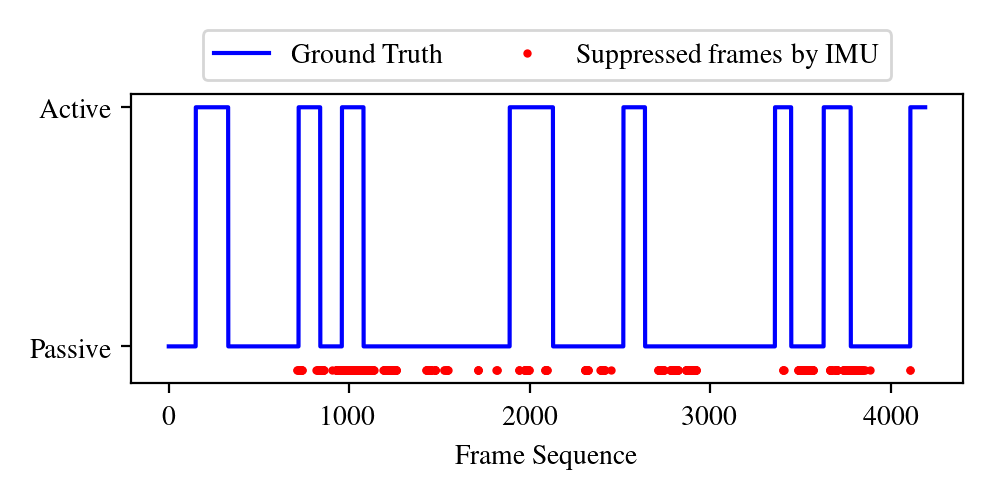

ikea-tr10
Using hand labeled GT: ikea-tr10
ikea-tr10 has 2100/5365 active/total frames
(5365,)


<IPython.core.display.Javascript object>


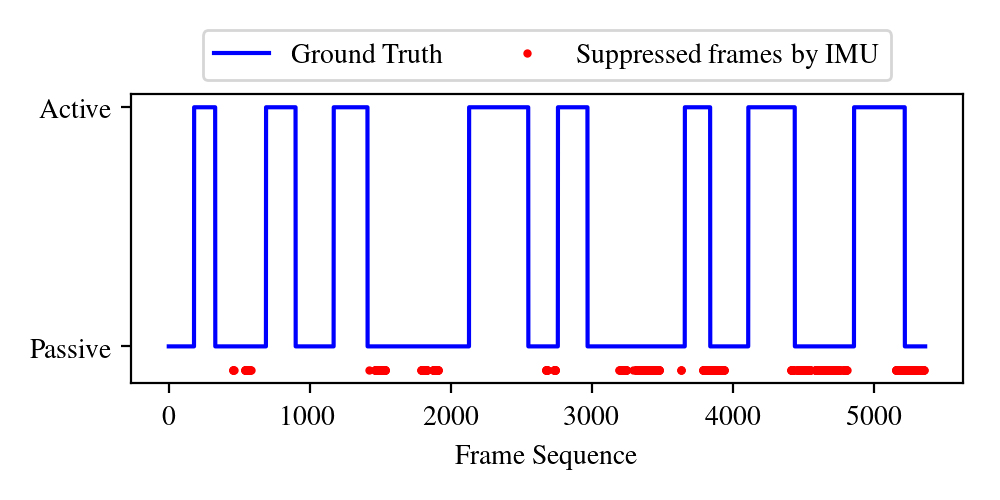

ikea-tr11
Using hand labeled GT: ikea-tr11
ikea-tr11 has 2160/5618 active/total frames
(5618,)


<IPython.core.display.Javascript object>


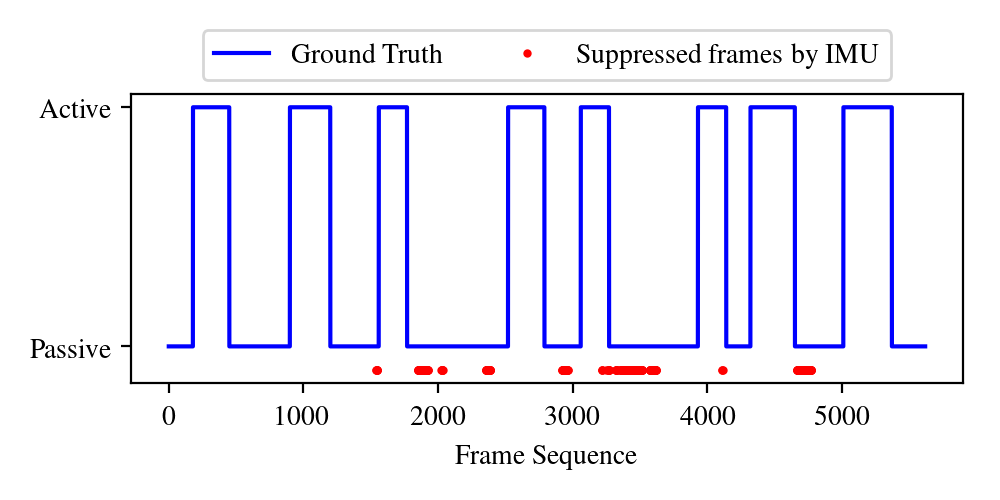

ikea-tr12
Using hand labeled GT: ikea-tr12
ikea-tr12 has 2520/4911 active/total frames
(4911,)


<IPython.core.display.Javascript object>


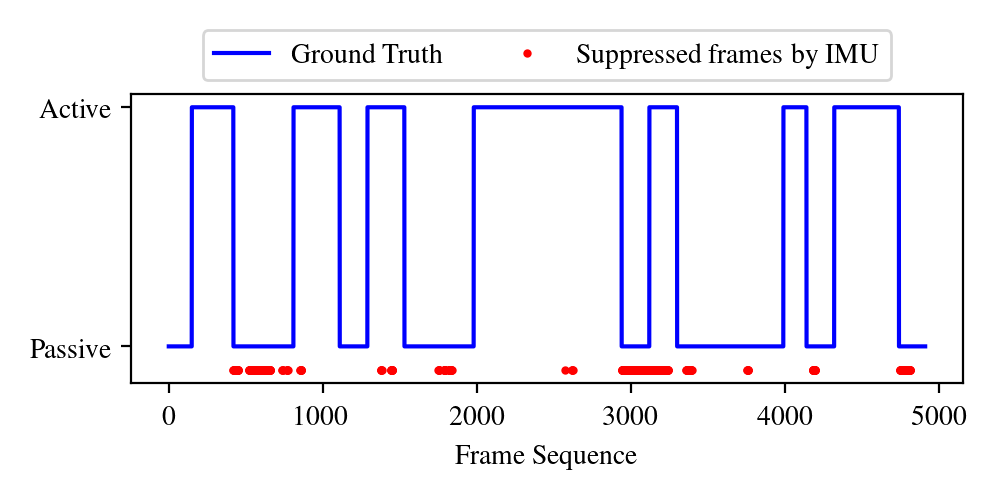

ikea-tr13
Using hand labeled GT: ikea-tr13
ikea-tr13 has 1920/4723 active/total frames
(4723,)


<IPython.core.display.Javascript object>


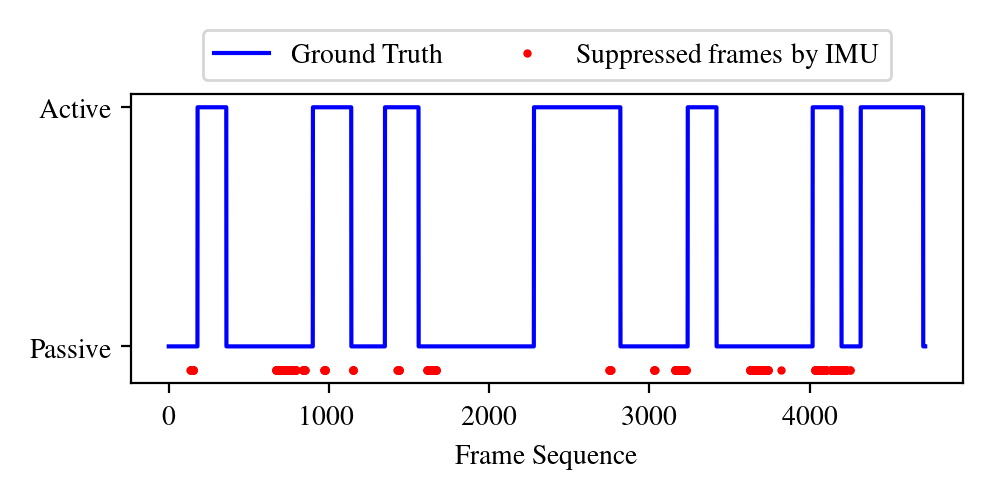

   dropped_active  dropped_passive  dropped_total trace_name
0        0.237534         0.166667       0.185309   ikea-tr8
1        0.065238         0.264931       0.186766  ikea-tr10
2        0.006019         0.127241       0.080634  ikea-tr11
3        0.055952         0.199080       0.125636  ikea-tr12
4        0.078646         0.131288       0.109888  ikea-tr13


In [253]:
%matplotlib notebook

clf = pickle.load(open('IMU_' + APP + '_clf.pkl', 'r'))
    
test_set_result = eval_load_and_latency(TEST_TRACES, clf)
test_set_result.to_csv('IMU_result.txt')
print(test_set_result)

In [121]:
# dirty playground
%matplotlib notebook

base_dir = '/home/junjuew/work/resource-management/data/ikea-trace'


def get_gt(trace,X1):
    ss_df = get_SS_pd(trace)
    ss_df = ss_df[ss_df['index'] < X1.shape[0]]
    y1 = np.zeros_like(X1[:, 0])
    active_inds = ss_df[filter_active(ss_df)]['index'].values
    y1[active_inds] = 1
    return y1

def get_raw_Xy(trace_name):
    trace_num = re.search('\d+', trace_name).group(0)
    csv_name = glob.glob(os.path.join(base_dir,
                                      trace_num, '*.csv'))[0]
    print("Using file as IMU data:", csv_name)
    df = pd.read_csv(csv_name,index_col='frame_id')
    use_imu_cols = ['rot_x','rot_y','rot_z','acc_x','acc_y','acc_z']
    X = df[use_imu_cols].values
    X = X - np.array(IMU_CALIBRATE)
    y = get_gt(trace_name,X)
    return X, y 

test-ikea-10
Using hand labeled GT: test-ikea-10
test-ikea-10 has 2100/5365 active/total frames


<IPython.core.display.Javascript object>


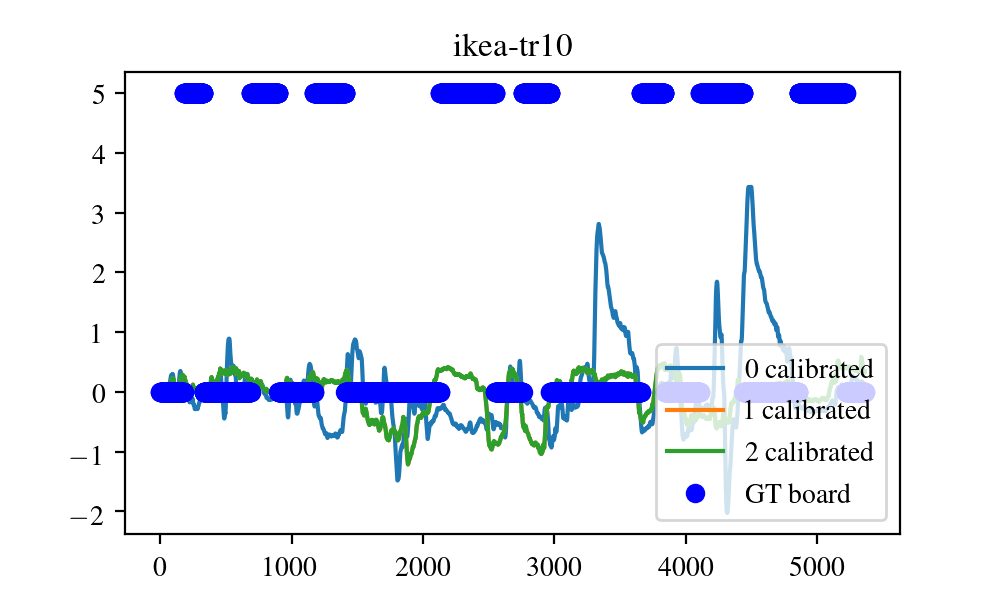

Corr coef:
 [[ 1.         -0.36047036]
 [-0.36047036  1.        ]]
test-ikea-11
Using hand labeled GT: test-ikea-11
test-ikea-11 has 2160/5618 active/total frames


<IPython.core.display.Javascript object>


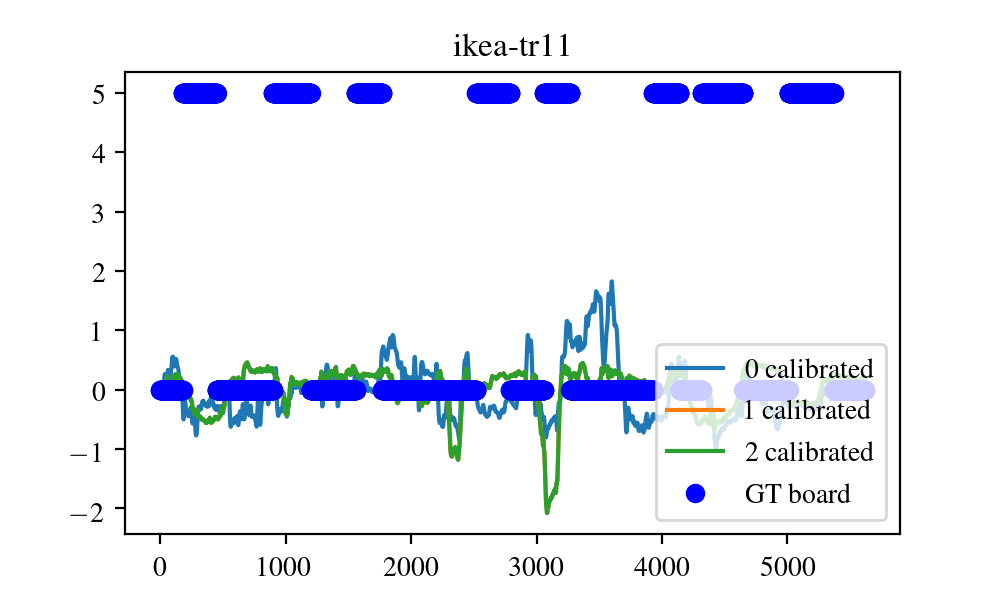

Corr coef:
 [[ 1.         -0.30757718]
 [-0.30757718  1.        ]]
test-ikea-12
Using hand labeled GT: test-ikea-12
test-ikea-12 has 2520/4911 active/total frames


<IPython.core.display.Javascript object>


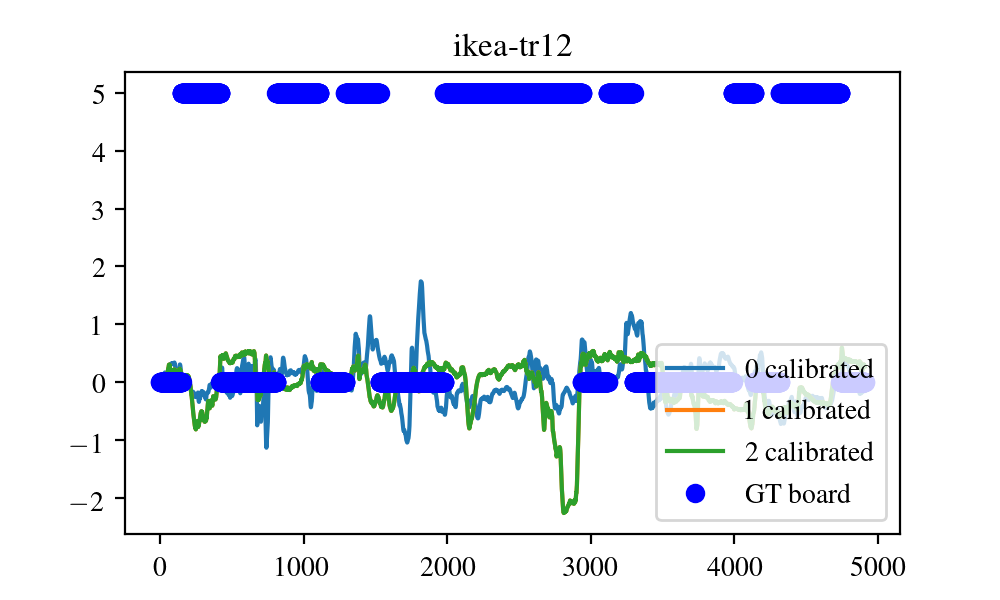

Corr coef:
 [[ 1.         -0.14586117]
 [-0.14586117  1.        ]]
test-ikea-13
Using hand labeled GT: test-ikea-13
test-ikea-13 has 1920/4723 active/total frames


<IPython.core.display.Javascript object>


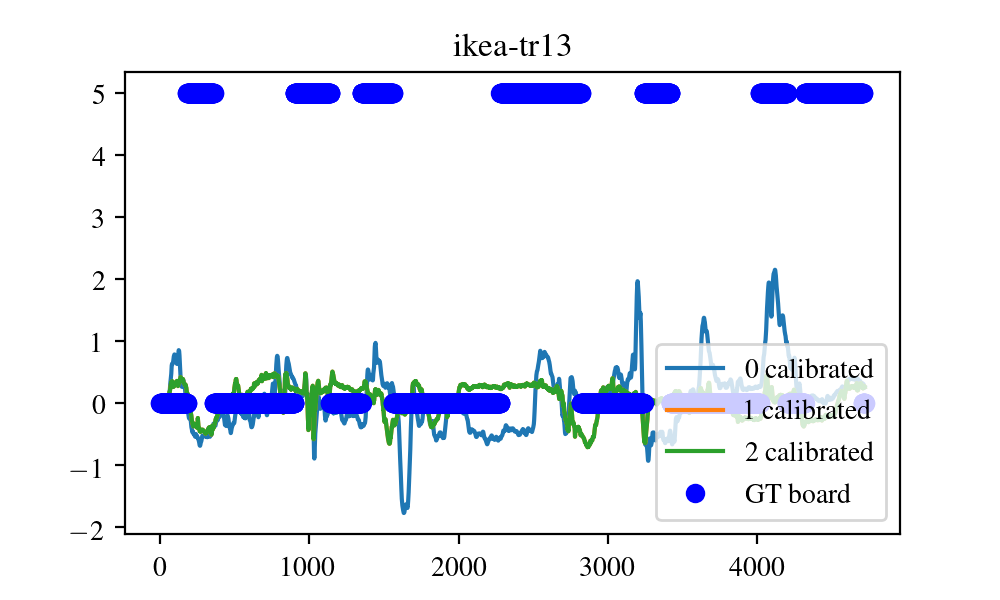

Corr coef:
 [[1.         0.06712015]
 [0.06712015 1.        ]]


In [214]:
for trace_name in sorted(set(TRAIN_TRACES + TEST_TRACES)):
    X, y = get_raw_Xy(trace_name)
#     X, y = get_X_y_csv(trace_name, base_dir)
#     X_uncalibrated, _ = get_raw_Xy(trace_name, calibrate=False)

    X_accx = X[:,3]

    X_smooth = past_windowed_1d(X_accx, 90, lambda w: np.mean(w))

    X_cummin = np.minimum.accumulate(X_smooth)
    X_cummax = np.maximum.accumulate(X_smooth)
    X_cummean = np.cumsum(X_smooth) / (np.arange(X_smooth.shape[0]) + 1)

    # X_star = X_smooth - np.cumsum(X_accx) / (np.arange(X_accx.shape[0]) + 1)
    # X_star = gaussian_filter1d(X_accx,10) - np.mean(X_accx)
    X_star = past_windowed_1d(X_accx, X_accx.shape[0], lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))

    y_pred = np.array(X_star < 0.1, dtype=np.int8)

    # hot fix: always transmit first 90 frames (~3 sec)
    y_pred[:90] = 1

    fn_inds = np.nonzero(np.logical_and(y == 1, y_pred == 0))[0]
    fp_inds = np.nonzero(np.logical_and(y == 0, y_pred == 1))[0]

    X_used = transform_acc_x(X)
    if True:
        plt.figure(figsize=(5,3))

        for i in range(3):
            plt.plot(X_used[:,i], label=str(i)+' calibrated')

        plt.plot(y*5, 'bo', label='GT board')
    #     plt.plot(X_accx, 'g', label ='acc x')

    #     plt.plot(X_smooth , 'k', label ='X smooth')
    #     plt.plot(X_cummean, 'c', label='cum mean')
    #     plt.plot(X_smooth < np.mean(X_smooth), label='offset mean')
    #     plt.plot(X_cummin, 'c', label ='X cummax')
    #     plt.plot(X_cummax, 'm', label ='X cummin')
    #     plt.plot(X_star, 'r', label ='acc x (smoothed&normalized)')
    #     plt.plot(gaussian_filter1d(X_accx,10), label='Gaussian smooth')
    #     plt.plot(fn_inds, np.ones_like(fn_inds) , 'yx', label = 'FN')
    #     plt.plot(fp_inds, np.zeros_like(fp_inds) , 'mx', label = 'FP')
        plt.legend(loc='lower right')
        plt.title(trace_name)

    print("Corr coef:\n", np.corrcoef(X_star, y))

In [241]:
def load_IMU_Suppression_to_DB(trace_name):
    clf = pickle.load(open('IMU_' + APP + '_clf.pkl', 'r'))
    cm, (_, y, y_pred) = eval_clf(clf, [trace_name,], X_transform_func=transform_acc_x)
    print(trace_name)
    print(cm)
    trace_num = re.search('\d+', trace_name).group(0)
    for idx in range(y_pred.shape[0]):
        keys_dict = {'name': trace_name,
                     'trace': trace_num,
                     'index': idx
                    }
        vals_dict = {'suppression': not bool(y_pred[idx]),
                    }
        
        insert_or_update_one(sess, models.IMUSuppression, keys_dict, vals_dict)

    print("Updated: ", len(sess.dirty))
    print("New: ", len(sess.new))
    sess.commit()



# sess = dbutils.get_session()
# for i, trace_name in enumerate(TRAIN_TRACES):
#     print(trace_name)
#     load_IMU_Suppression_to_DB(trace_name)
# sess.close()

ikea-tr12
test-ikea-12
Using hand labeled GT: test-ikea-12
test-ikea-12 has 2520/4911 active/total frames
ikea-tr12
[[ 476 1915]
 [ 141 2379]]
Updated:  0
New:  1
ikea-tr13
test-ikea-13
Using hand labeled GT: test-ikea-13
test-ikea-13 has 1920/4723 active/total frames
ikea-tr13
[[ 368 2435]
 [ 151 1769]]
Updated:  0
New:  1


ikea-tr2
Detected Objects: base [0.68428195 0.43848    0.98812175 0.74581337]
[618, 982, 1100, 1706, 4693, 4760]


Using file as IMU data: /home/junjuew/work/resource-management/data/ikea-trace/8/2019_05_18-02_01_08.csv


/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Discarding nonzero nanoseconds in conversion
  This is separate from the ipykernel package so we can avoid doing imports until


Updated:  0
New:  1
